<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/01_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Sequences

In this notebook, we’ll dive into a new kind of input: sequences!

In sequence problems, an ordered sequence of data points shares a single
label—emphasis on being ordered.

Why is ordered so important?

If the data points aren’t ordered, even if they share a single label, they are not a
sequence, but rather a collection of data points.

If the data structure has a single dimension, though, that’s a sequence. This
particular structure can be exploited by recurrent neural networks and their many
variants, as well as by 1D convolutional neural networks.

There are two main types of sequence problems: time series and natural language
processing (NLP). 

We’ll start by generating a synthetic dataset and then use it to
illustrate the inner workings of:

1. recurrent neural networks, 
2. encoder-decoder models, 
3. attention mechanisms, and 
4. Transformers



##Setup

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter8()
# This is needed to render the plots in this chapter
from plots.chapter8 import *

Finished!


In [2]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils import rnn as rnn_utils

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset

Our data points are two-dimensional, so they can be visualized as an image, and
ordered, so they are a sequence.

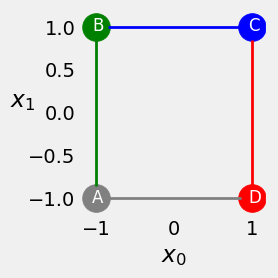

In [4]:
fig = counter_vs_clock(draw_arrows=False)

Now, we can choose to draw it clockwise or counterclockwise

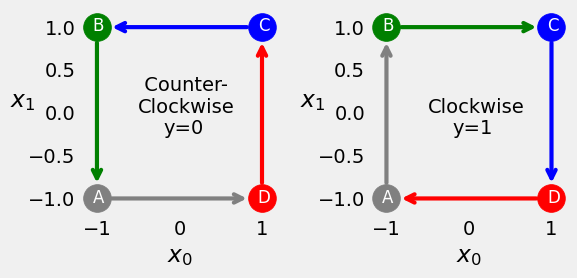

In [5]:
fig = counter_vs_clock()

Since there are four corners to start from, and there are two directions to follow,
there are effectively eight possible sequences.

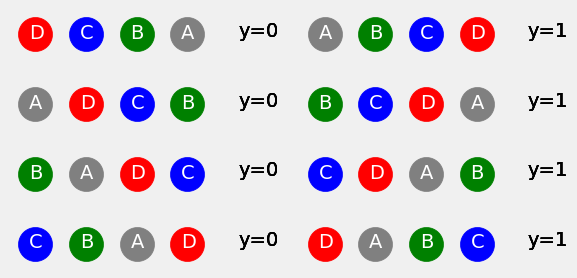

In [6]:
fig = plot_sequences()

Let’s generate 128 random noisy squares.

In [7]:
points, directions = generate_sequences(n=128, seed=13)

And then let’s visualize the first ten squares.

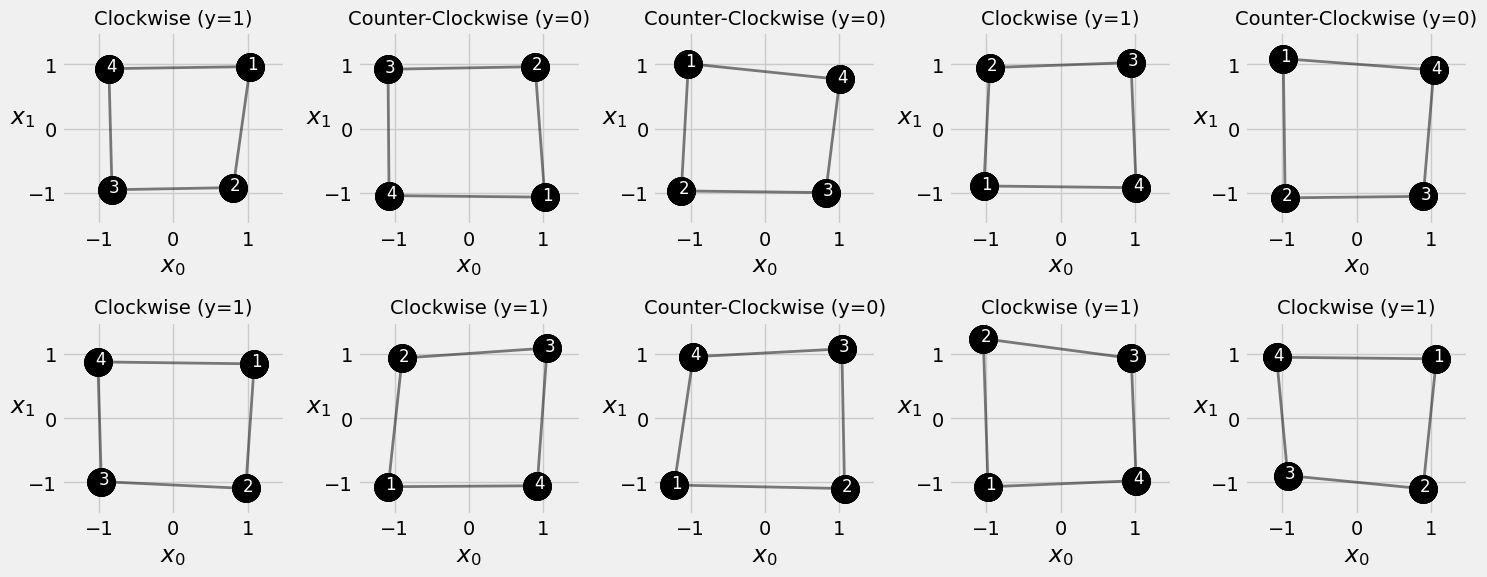

In [8]:
fig = plot_data(points, directions)

##Recurrent Neural Networks

Recurrent neural networks are perfectly suited for sequence problems since they
take advantage of the underlying structure of the data, namely, the order of the
data points.

A hidden state is simply a vector. The size of the vector is up to
you. Really. You need to specify the number of hidden dimensions, which means
specifying the size of the vector that represents a hidden state. 

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/rnn2.png?raw=1)

Let’s create a two dimensional
hidden state.

In [10]:
hidden_state = torch.zeros(2)
hidden_state

tensor([0., 0.])

Since the final hidden state is a representation of the full sequence, that’s what
we’re going to use as features for our classifier.

There is a fundamental difference between CNNs and RNNs, though: While there
are several different convolutional layers, each learning its own filters, the RNN
cell is one and the same.

###RNN Cell

There is only one cell, which will learn a particular set of weights
and biases, and which will transform the inputs exactly the same
way in every step of the sequence.

Let’s take a look at some of the internals of an RNN cell.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/rnn1.png?raw=1)

It has three main components:

1. A linear layer to transform the hidden state (in blue)
2. A linear layer to transform the data point from the sequence (in red)
3. An activation function, usually the hyperbolic tangent (TanH), which is applied to the sum of both transformed inputs

We can also represent them as equations:

$$
\Large
\begin{array}
&\text{RNN}: &\color{#0066CC}{t_h}&\color{#0066CC}{=}&\color{#0066CC}{W_{hh}}&\color{#0066CC}{h_{t-1}}&\color{#0066CC}{+}&\color{#0066CC}{b_{hh}}
\\
&\color{red}{t_x}& \color{red}{=} &\color{red}{W_{ih}}&\color{red}{x_{t}}&\color{red}{+}&\color{red}{b_{ih}}
\\
&\color{#0066CC}{h_t}&\color{#0066CC}{=}&\color{#0066CC}{\text{tanh}}&\color{#0066CC}{(t_h}&\color{#0066CC}{+}&\color{#0066CC}{t_x)}
\end{array}
$$

But there is no other cell, really; it is just the same cell over and over again.

So, in the second step of the
sequence, the updated hidden state will run through the very same linear layer the
initial hidden state ran through. The same goes for the second data point.

Let’s dive deeper into the internals of an RNN cell and look at it at the neuron level:

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/rnn_cell_diagram.png?raw=1)

Since one can choose the number of hidden dimensions, I chose two dimensions,
simply because I want to be able to easily visualize the results. Hence, two blue
neurons are transforming the hidden state.


The number of red neurons transforming the data point will
necessarily be the same as the chosen number of hidden
dimensions since both transformed outputs need to be added
together. But this doesn’t mean the data points must have the
same number of dimensions.

Coincidentally, our data points have two coordinates, but even if
we had 25 dimensions, these 25 features would still be mapped
into two dimensions by the two red neurons.

Why hyperbolic tangent? Isn’t ReLU a better activation function?

The hyperbolic tangent has a "competitive advantage" here since it maps the feature
space to clearly defined boundaries: the interval (-1, 1). This guarantees that, at every step of the sequence, the hidden state is always within these boundaries.
Given that we have only one linear layer with which to transform the hidden
state, regardless of which step of the sequence it is being used in, it is definitely
convenient to have its values within a predictable range.

Now, let’s see how an RNN cell works in code.


In [12]:
torch.manual_seed(19)

n_features = 2
hidden_dim = 2

rnn_cell = nn.RNNCell(input_size=n_features, hidden_size=hidden_dim)
rnn_state = rnn_cell.state_dict()
rnn_state

OrderedDict([('weight_ih',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih', tensor([0.4954, 0.6533])),
             ('bias_hh', tensor([-0.3565, -0.2904]))])

We can use these weights to create two linear layers: